In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from tqdm import tqdm

# Data Loading

In [22]:
LOCATION_MAPPING = {
    "Tamaki Drive - Parnell": "Tamaki Drive",
    "Waterview Unitec Shared Path": "Waterview Unitec",
    "Mangere Bridge": "Mangere Foot Bridge",
    "Franklin Road": "Franklin Rd",
    "Symonds St Total": "Symonds St",
    "Oceanview Rd": "Ocean View Rd",
    "TeWero Bridge Bike Counter": "TeWero Bridge",
    "Victoria Street West": "Victoria St West",
    "TeAtatu Peninsula Shared Path": "TeAtatu Peninsula",
    "Lake Road Total Cyclists New": "Lake Rd",
    "Great South Rd Manukau": "Great South Rd",
    "Twin Streams Shared Path": "Twin Streams",
}

def load_cycle_counts(url: str) -> pd.DataFrame:
    if "august" in url or "september" in url:
        df = pd.read_excel(url, na_values="z", usecols="G:CG")
    else:
        df = pd.read_excel(url, na_values="z", header=2)
    
    df = df.rename(columns={"Date": "Time", "Date.1": "Time"})
    df = df.melt(id_vars="Time", var_name="Location", value_name="Count")
    
    df["Count"] = df["Count"].fillna(0)
    df["Location"] = df["Location"].str.replace(r" Cyclists?$", "", regex=True)
    df["Location"] = df["Location"].str.replace(r"\bDr\b", "Drive", regex=True)
    df["Location"] = df["Location"].replace(LOCATION_MAPPING)

    df.columns = df.columns.str.lower()
    df = df.astype({"time": "datetime64[s]", "location": str, "count": int})
    return df

In [23]:
urls = [
    "https://at.govt.nz/media/bb4h3wd3/at-daily-cycle-counts-january-2024.xlsx",
    "https://at.govt.nz/media/xlcaru0v/at-daily-cycle-counts-feb-2024.xlsx",
    "https://at.govt.nz/media/4g3hzpp5/at-daily-cycle-counts-march-2024.xlsx",
    "https://at.govt.nz/media/htvezqdn/at-daily-cycle-counts-april-2024.xlsx",
    "https://at.govt.nz/media/ue5cygl0/at-daily-cycle-counts-may-2024.xlsx",
    "https://at.govt.nz/media/3icd2jug/at-daily-cycle-counts-june-2024.xlsx",
    "https://at.govt.nz/media/jbdd1rox/cycle-counts-july-2024.xlsx",
    "https://at.govt.nz/media/bvadzmqg/cycle-counts-august-2024.xlsx",
    "https://at.govt.nz/media/lpsfdwbe/auckland-transport-cycle-counts-september-2024.xlsx",
    "https://at.govt.nz/media/ohbhvmrl/auckland-transport-cycle-movements-october-2024.xlsx",
]

dfs = []
for url in tqdm(urls):
    df = load_cycle_counts(url)
    dfs.append(df)

cycle_counts = pd.concat(dfs, ignore_index=True)
cycle_counts = cycle_counts.groupby(["time", "location"]).sum().reset_index()

100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


In [30]:
cycle_counts.to_csv("cycle_counts.csv", index=False)

In [ ]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["time"])

## EDA

### Total counts by day

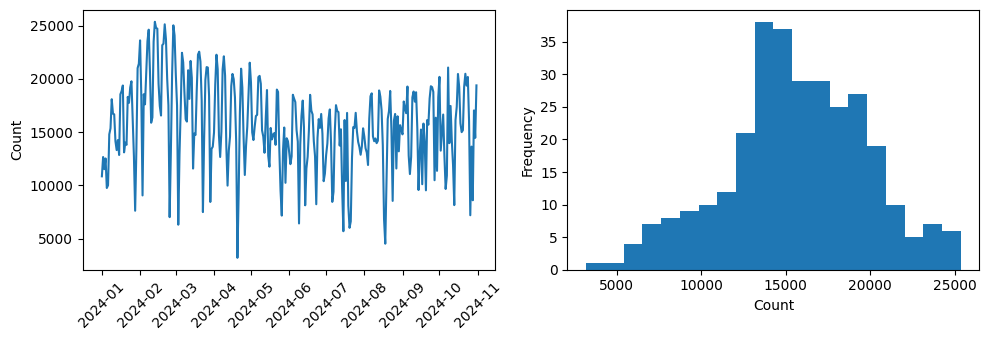

In [24]:
daily_total = cycle_counts.groupby("time")[["count"]].sum().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

ax[0].plot(daily_total["time"], daily_total["count"])
ax[0].set(ylabel="Count")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1].hist(daily_total["count"], bins=20);
ax[1].set(xlabel="Count", ylabel="Frequency")

fig.tight_layout()

### Daily counts by location

[Text(0, 0.5, 'Log(Count)')]

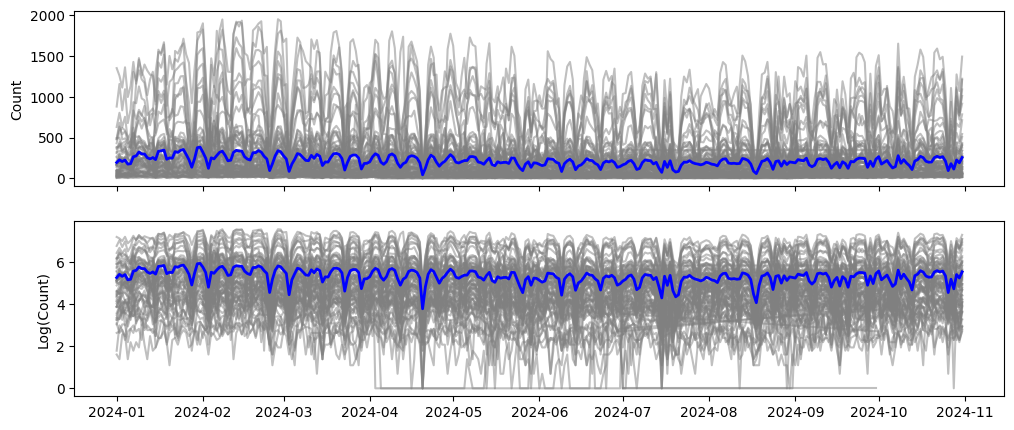

In [25]:
av_daily_counts = cycle_counts.groupby("time")[["count"]].mean().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

locations = cycle_counts["location"].unique()
for location in locations:
    location_df = cycle_counts[cycle_counts["location"] == location]
    ax[0].plot(location_df["time"], location_df["count"], color="gray", alpha=0.5)
    ax[1].plot(location_df["time"], np.log1p(location_df["count"]), color="gray", alpha=0.5)

ax[0].plot(av_daily_counts["time"], av_daily_counts["count"], color="blue", linewidth=2)
ax[1].plot(av_daily_counts["time"], np.log1p(av_daily_counts["count"]), color="blue", linewidth=2)

ax[0].set(ylabel="Count")
ax[1].set(ylabel="Log(Count)")

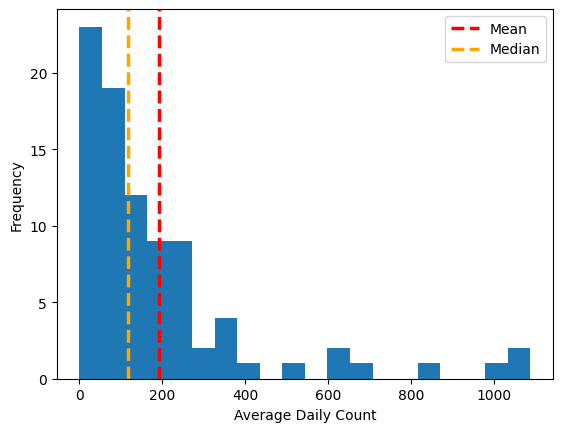

In [26]:
av_daily_counts_by_loc = cycle_counts.groupby("location")[["count"]].mean().reset_index()
av_daily_counts_by_loc = av_daily_counts_by_loc.sort_values("count").reset_index(drop=True)

mean_counts = av_daily_counts_by_loc["count"].mean()
median_counts = av_daily_counts_by_loc["count"].median()

fig, ax = plt.subplots(1, 1)
ax.hist(av_daily_counts_by_loc["count"], bins=20)
ax.axvline(mean_counts, color="red", linestyle="--", lw=2.5, label="Mean")
ax.axvline(median_counts, color="orange", linestyle="--", lw=2.5, label="Median")
ax.set(xlabel="Average Daily Count", ylabel="Frequency")
ax.legend();

### High demand locations

In [27]:
threshold = 600
high_demand_locs = av_daily_counts_by_loc[av_daily_counts_by_loc["count"] > threshold]
high_demand_locs.sort_values("count")

,location,count
80,NW Cycleway TeAtatu,622.639344
81,Nelson St,649.626230
82,Lightpath,684.593443
83,Quay St - Spark Arena,854.940984
84,Tamaki Drive,1026.918033
85,Quay St Eco Display Classic,1065.940984
86,NW Cycleway Kingsland,1088.026230


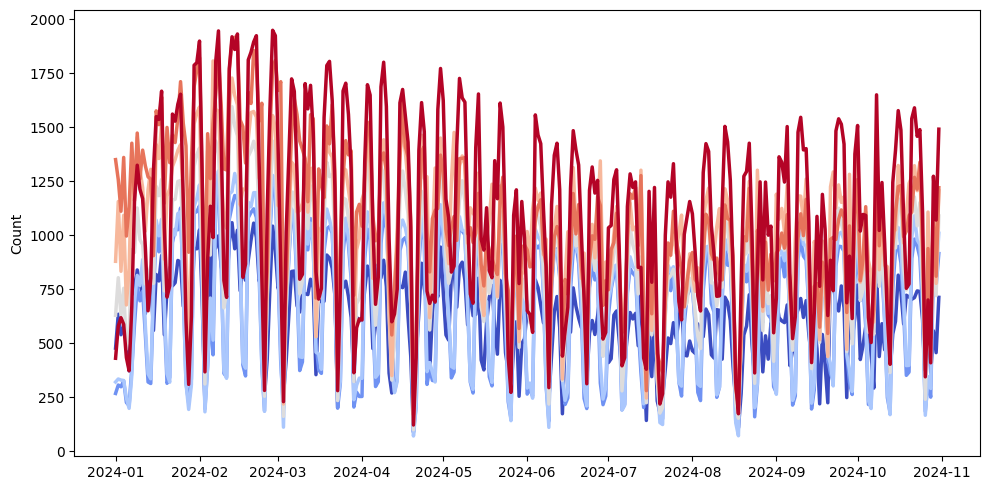

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

locations = high_demand_locs["location"].values
colors = cm.coolwarm(np.linspace(0, 1, len(locations)))
for i, location in enumerate(locations):
    location_df = cycle_counts[cycle_counts["location"] == location]
    ax.plot(
        location_df["time"],
        location_df["count"],
        label=location,
        color=colors[i],
        lw=2.5,
    )
ax.set(ylabel="Count")
fig.tight_layout();

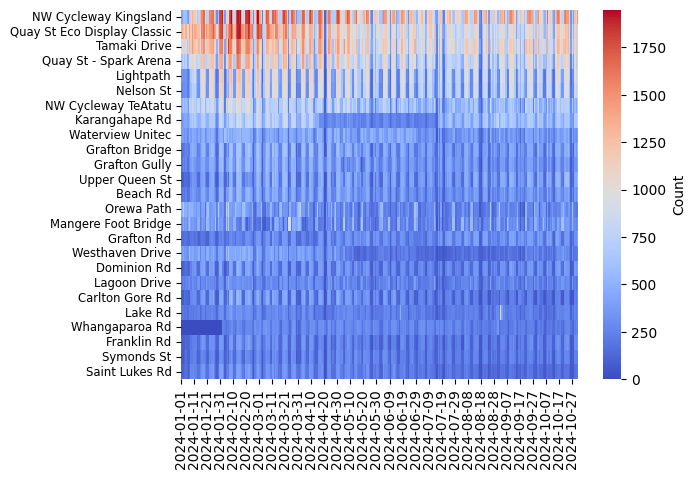

In [29]:
counts_pivot = cycle_counts.pivot_table(columns="time", index="location", values="count", aggfunc="sum")
counts_pivot = counts_pivot.fillna(0).assign(average=lambda x: x.mean(axis=1))
counts_pivot = counts_pivot[counts_pivot["average"].between(200, 2500)]
counts_pivot = counts_pivot.sort_values("average", ascending=False).drop(columns="average")

fig, ax = plt.subplots(1, 1)
sns.heatmap(counts_pivot, cmap="coolwarm", cbar_kws={"label": "Count"})

xs = np.arange(0, counts_pivot.shape[1], 10)
xticklables = [c.strftime("%Y-%m-%d") for c in counts_pivot.columns[xs]]
ax.set(xticks=xs, xticklabels=xticklables)

ys = np.arange(0, counts_pivot.shape[0])
yticklables = counts_pivot.index[ys]
ax.set_yticks(ys + 0.5)
ax.set_yticklabels(yticklables, fontsize="small")

ax.set(xlabel="", ylabel="");